## **Load des données et animations** ##



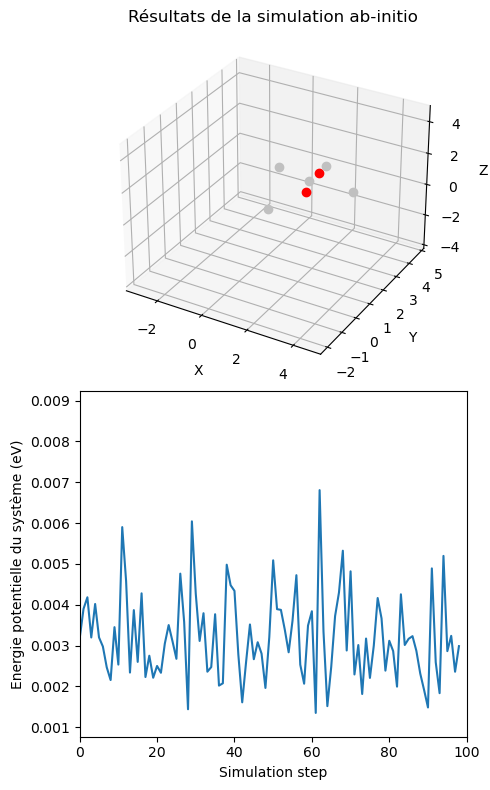

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import pandas as pd

%matplotlib inline 

#Loader du fichier .xyz
def load_data():
    o1_index=[2]
    o2_index=[3]
    h1_index=[4]
    h2_index=[5]
    h3_index=[6]
    h4_index=[7]
    h5_index=[8]

    o1=[]
    o2=[]
    h1=[]
    h2=[]
    h3=[]
    h4=[]
    h5=[]

    with open("new_positions_sparse.xyz", 'r') as infile:

        for index, line in enumerate(infile):
            items = line.split()

            if index%9 in o1_index:
                kind, x, y, z = items[0], float(items[1]), float(items[2]), float(items[3])
                o1.append([0,x,y,z])

            if index%9 in o2_index:
                kind, x, y, z = items[0], float(items[1]), float(items[2]), float(items[3])
                o2.append([0,x,y,z])

            if index%9 in h1_index:
                kind, x, y, z = items[0], float(items[1]), float(items[2]), float(items[3])
                h1.append([1,x,y,z])   

            if index%9 in h2_index:
                kind, x, y, z = items[0], float(items[1]), float(items[2]), float(items[3])
                h2.append([1,x,y,z])

            if index%9 in h3_index:
                kind, x, y, z = items[0], float(items[1]), float(items[2]), float(items[3])
                h3.append([1,x,y,z])

            if index%9 in h4_index:
                kind, x, y, z = items[0], float(items[1]), float(items[2]), float(items[3])
                h4.append([1,x,y,z])

            if index%9 in h5_index:
                kind, x, y, z = items[0], float(items[1]), float(items[2]), float(items[3])
                h5.append([1,x,y,z])
                
    return np.concatenate((o1, o2, h1, h2, h3, h4, h5), axis=1).reshape(10000, 7, 4) #10000 fois 7 colomnes de 4 éléments  (particule, x, y, z)

#Loader de l'output de la simulation (fichier .out)
output=pd.read_csv('new_energies_sparse.out', sep=' ', header=None)

#Extraction des énergies (5eme colonne)
energies=output[5]

#Load du fichier .xyz
dataset=load_data()


#################
# Plot des données (Animation 3D + Energie)
#################

#Nombre de data utilisées pour l'animation
N=100

#Init animation 2D
def init():
    return graph,

#Fonction update plot energies
def update_en(num):
    graph.set_data(x[:num],y[:num])
    return graph,

#Mise en forme des trajectoires
def transform_data(X, Y, Z):
    t = np.vstack((X, Y, Z))
    return t

#Fonction update pour le plot des trajectoires
def update_lines(num, dataLines, lines) :
    for line, data in zip(lines, dataLines) :
        line.set_data(data[0:2, num-1:num])
        line.set_3d_properties(data[2,num-1:num])
    return lines

#Fonction update des deux plots
def update_both(num, data2, line2):
    update_en(num)
    update_lines(num, data2, line2)
    
#Création de la figure
fig= plt.figure(figsize=(5, 8))

#ax1 = plot des énergies
ax1=fig.add_subplot(2, 1, 2) 
ax1.set_xlim(0, N)
ax1.set_ylim(np.min(energies), np.max(energies))
ax1.set_xlabel("Simulation step")
ax1.set_ylabel("Energie potentielle du système (eV)")

graph, = plt.plot([], [], '-')

#ax = plot des trajectoires
ax=fig.add_subplot(2, 1, 1, projection='3d')

ax.set_xlim3d([np.min(dataset[:, :, 1][:N]), np.max(dataset[:, :, 1][:N])])
ax.set_xlabel('X')

ax.set_ylim3d([np.min(dataset[:, :, 2][:N]), np.max(dataset[:, :, 2][:N])])
ax.set_ylabel('Y')

ax.set_zlim3d([np.min(dataset[:, :, 3][:N]), np.max(dataset[:, :, 3][:N])])
ax.set_zlabel('Z')

ax.set_title('Résultats de la simulation ab-initio')

plt.tight_layout()

# Données de l'énergie
x = range(N)
y = energies[:N]

# Données 3D
data=[]
lines=[]
colors=['r', 'r', 'silver', 'silver', 'silver', 'silver', 'silver'] #couleur des atomes
for i in range(dataset.shape[1]):
    coord=dataset[:, i][:N]
    X=coord[:, 1]
    Y=coord[:, 2]
    Z=coord[:, 3]
    data.append(transform_data(X, Y, Z))
    
    lines.append(ax.plot(data[0][0,0:1], data[0][1,0:1], data[0][2,0:1], 'o', color=colors[i])[0])

# Objet d'animation
ani = animation.FuncAnimation(fig, update_both, len(X), fargs=(data, lines),
                              interval=100, blit=False)

ani.save('ab-initio.mp4')
plt.show()

## **Mise en place des descripteurs (matrice de Coulomb)** ##

In [154]:
from ase import Atoms
from dscribe.descriptors import CoulombMatrix

#Fonction pour la création de la matrice de Coulomb à partir d'un dataset
def create_CM(data):
    cm = CoulombMatrix(n_atoms_max=7)
    zundel_steps=[]
    for i in range(data.shape[0]):
        zundel_steps.append(cm.create(Atoms("O2H5", [(data[i][j][1], data[i][j][2], data[i][j][3]) for j in range(data.shape[1])])))
    return np.array(zundel_steps)

## **Séparation et exploration statistique des données**. ##

data shape : (10000, 7, 4)
target shape : (10000,)


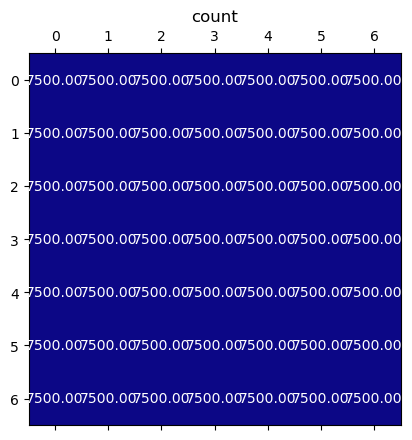

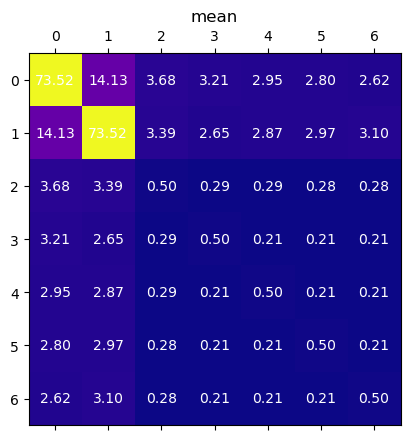

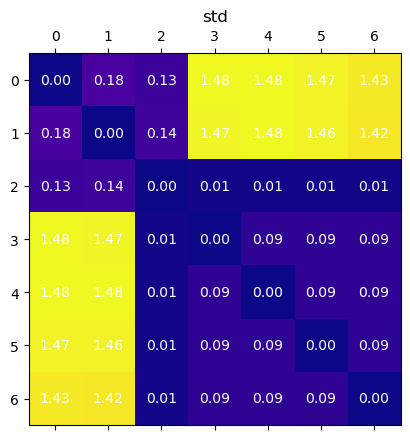

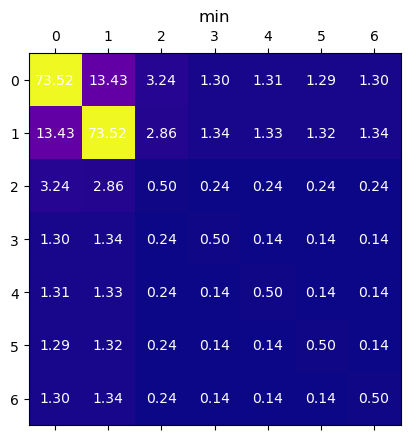

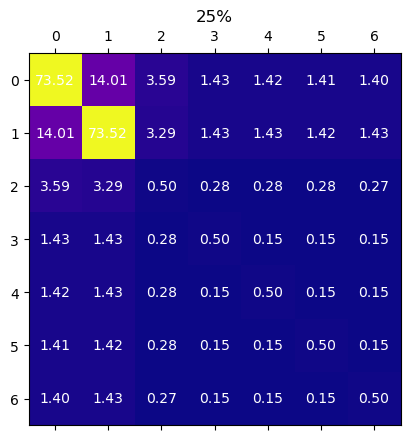

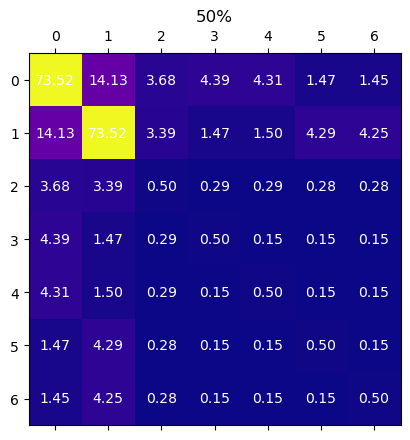

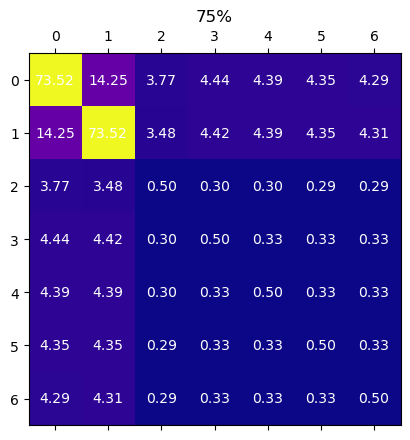

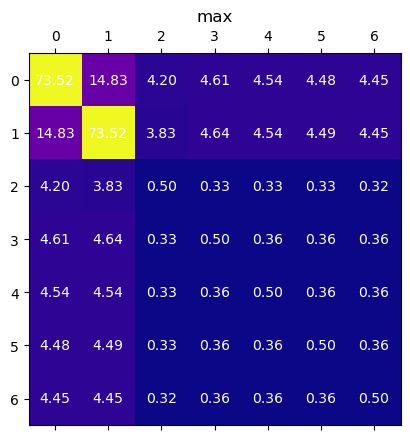

In [155]:
#Séparation des données
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

print("data shape :", dataset.shape)
print("target shape :", energies.shape)
X_train, X_test, y_train, y_test=train_test_split(dataset, energies, random_state=22)

#création des matrices de Coulomb pour les données d'entrainement
X_train_CM=create_CM(X_train)
X_test_CM=create_CM(X_test)

#conversion dans un Dataset pour explorer les données statistiquement avec les outils pandas
X_train_DF=pd.DataFrame(X_train_CM)

stat=X_train_DF.describe()

statnp=stat.to_numpy().reshape(8, 7, 7)

for i, l in enumerate(stat.index):
    #plt.subplot(2, 4, i+1)
    plt.matshow(statnp[i], cmap="plasma")
    for (x, y), value in np.ndenumerate(statnp[i]):
        plt.text(x, y, f"{value:.2f}", va="center", ha="center", color="white")
    plt.title(l)


Text(0.5, 1.0, 'Exemple de matrice de Coulomb')

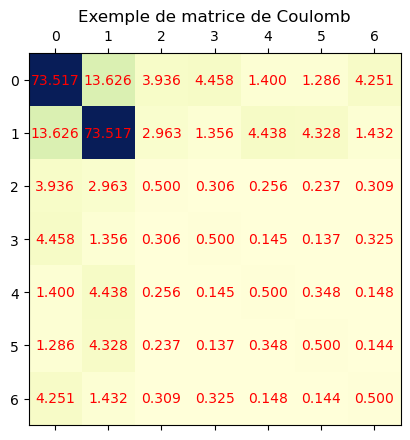

In [156]:
plt.matshow(create_CM(X_train)[0].reshape(7, 7), cmap="YlGnBu")

for (x, y), value in np.ndenumerate(create_CM(X_train)[0].reshape(7, 7)):
    plt.text(x, y, f"{value:.3f}", va="center", ha="center", color="red")
    
plt.title("Exemple de matrice de Coulomb")

Réduction des données


In [164]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_CM_red=scaler.fit_transform(X_train_CM)
X_test_CM_red=scaler.fit_transform(X_test_CM)

#scaling des y
y_train_scaled=y_train/np.max(y_train)**2
y_test_scaled=y_test/np.max(y_test)**2

In [165]:
X_train_CM.shape

(7500, 49)

### Eigenspectrum ###

In [166]:
def create_CM_eigen(data):
    cm = CoulombMatrix(n_atoms_max=7, permutation='eigenspectrum')
    zundel_steps=[]
    for i in range(data.shape[0]):
        zundel_steps.append(cm.create(Atoms("O2H5", [(data[i][j][1], data[i][j][2], data[i][j][3]) for j in range(data.shape[1])])))
    return np.array(zundel_steps)

In [167]:
pd.DataFrame(create_CM_eigen(X_train)).describe()

,0,1,2,3,4,5,6
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,88.701505,59.682468,0.417565,0.242826,0.173534,0.162842,0.152649
std,0.183102,0.177838,0.009194,0.006553,0.004729,0.004301,0.005124
min,87.977655,58.979104,0.388062,0.219960,0.157364,0.143278,0.131788
25%,88.582326,59.559842,0.411327,0.238478,0.170198,0.159958,0.149336
50%,88.705274,59.678830,0.417490,0.242890,0.173346,0.162958,0.152911
75%,88.827863,59.797708,0.423616,0.247244,0.176679,0.165817,0.156172
max,89.435804,60.383806,0.453386,0.267795,0.194823,0.178765,0.169214


In [168]:
X_train_CMe=create_CM_eigen(X_train)
X_test_CMe=create_CM_eigen(X_test)
X_train_CMe_red=scaler.fit_transform(X_train_CMe)
X_test_CMe_red=scaler.fit_transform(X_test_CMe)

## **Prédicteur naif** ##

In [172]:
from sklearn.metrics import mean_squared_error

def naive_predictor(xtrain, ytrain):
    return np.ones((xtrain.shape[0],))*ytrain.mean()

y_fit=naive_predictor(X_train_CM_red, y_train_scaled)
y_pred_test=naive_predictor(X_test_CM_red, y_train_scaled)


mse=mean_squared_error(np.array(y_train_scaled), y_fit)
mse_test=mean_squared_error(np.array(y_test_scaled), y_pred_test)
print(mse)
print(mse_test)

147.60835799504767
478.4655468772903


## **Modèle linéaire** ##

In [188]:
from sklearn.linear_model import RidgeCV

a=np.logspace(-10, 10, 1000)
model=RidgeCV(alphas=a)
model.fit(X_train_CM_red, y_train_scaled)

print("Best regularization parameter :", model.alpha_)
print("RMSE moyen:", -model.best_score_)

y_pred_test_rcv=model.predict(X_test_CM_red)
mse_test_rcv=mean_squared_error(np.array(y_test_scaled), y_pred_test_rcv)
print(mse_test_rcv)

Best regularization parameter : 9862.65846131283
RMSE moyen: 147.54793975124082
478.2403569222022


In [189]:
from sklearn.linear_model import ElasticNetCV

a=np.logspace(-10, 10)
model=ElasticNetCV(alphas=a, max_iter=1000000)
model.fit(X_train_CM_red, y_train_scaled)

print("Best regularization parameter :", model.alpha_)
#print("RMSE moyen:", -model.best_score_)

y_pred_train_en=model.predict(X_train_CM_red)
mse_train_en=mean_squared_error(np.array(y_train_scaled), y_pred_train_en)
print(mse_train_en)


y_pred_test_en=model.predict(X_test_CM_red)
mse_test_en=mean_squared_error(np.array(y_test_scaled), y_pred_test_en)
print(mse_test_en)

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.1265452526277, tolerance: 87.68858683318697
  model = cd_fast.enet_coordinate_descent_gram(


Best regularization parameter : 0.2442053094548655
147.31596081980524
478.22825923112975


In [190]:
from sklearn.kernel_ridge import KernelRidge

mse_test_krr=[]
A=np.logspace(-10, 10, 10)
for a in A:
    krr = KernelRidge(alpha=a)
    krr.fit(X_train_CM_red, y_train_scaled)

    y_pred_test_krr=krr.predict(X_test_CM_red)

    mse_test=mean_squared_error(np.array(y_test_scaled), y_pred_test_krr)
    mse_test_krr.append(mse_test)

In [191]:
krr = KernelRidge(alpha=1)
krr.fit(X_train_CM_red, y_train_scaled)

y_pred_test_krr=krr.predict(X_test_CM_red)

mse_test=mean_squared_error(np.array(y_test_scaled), y_pred_test_krr)


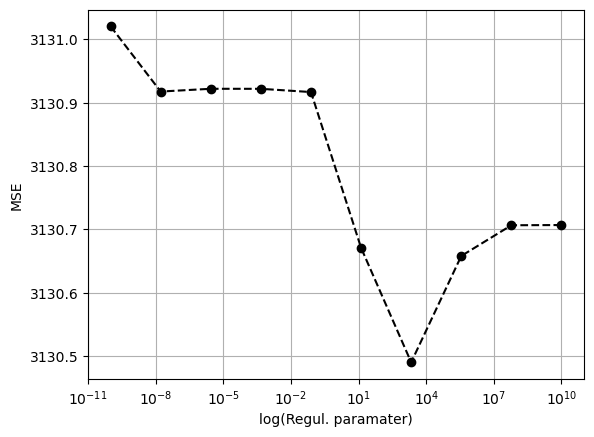

In [192]:
plt.semilogx(A, mse_test_krr, marker='o', linestyle='--', color='black')
plt.xlabel("log(Regul. paramater)")
plt.ylabel("MSE")
plt.grid(True, which="both", ls="-")
plt.show()

In [193]:
print("Best score KRR :", np.min(mse_test_krr))
idx=np.where(np.array(mse_test_krr)==np.min(mse_test_krr))
print("Best param KRR :", A[idx])

Best score KRR : 3130.49043119472
Best param KRR : [2154.43469003]


In [194]:
krr.predict(X_train_CM_red)

array([ 2.83380688, -0.28142056,  0.84790163, ..., -0.23045972,
       -0.26879695, -1.80012947])

## **Réseau de neurones** ##

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               10000     
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 90,601
Trainable params: 90,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2022-11-18 16:02:04.018198: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-18 16:02:04.018301: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-11-18 16:02:04.177211: W tensorflow/core/platform/profile_utils

 1/94 [..............................] - ETA: 30s - loss: 1430.4565 - mean_squared_error: 1430.4565

2022-11-18 16:02:04.351493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 1s 9ms/step - loss: 443.4129 - mean_squared_error: 443.4129 - val_loss: 176.3809 - val_mean_squared_error: 176.3809
Epoch 2/100
 9/94 [=>............................] - ETA: 0s - loss: 164.4144 - mean_squared_error: 164.4144

2022-11-18 16:02:05.249145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 1s 8ms/step - loss: 154.2988 - mean_squared_error: 154.2988 - val_loss: 148.5312 - val_mean_squared_error: 148.5312
Epoch 3/100
94/94 [==============================] - 1s 8ms/step - loss: 147.5349 - mean_squared_error: 147.5349 - val_loss: 148.1629 - val_mean_squared_error: 148.1629
Epoch 4/100
94/94 [==============================] - 1s 8ms/step - loss: 147.5034 - mean_squared_error: 147.5034 - val_loss: 148.1721 - val_mean_squared_error: 148.1721
Epoch 5/100
94/94 [==============================] - 1s 8ms/step - loss: 147.4606 - mean_squared_error: 147.4606 - val_loss: 148.1594 - val_mean_squared_error: 148.1594
Epoch 6/100
94/94 [==============================] - 1s 8ms/step - loss: 147.5083 - mean_squared_error: 147.5083 - val_loss: 148.1706 - val_mean_squared_error: 148.1706
Epoch 7/100
94/94 [==============================] - 1s 8ms/step - loss: 147.4838 - mean_squared_error: 147.4838 - val_loss: 148.1674 - val_mean_squared_error: 148.167

94/94 [==============================] - 1s 8ms/step - loss: 111.2890 - mean_squared_error: 111.2890 - val_loss: 161.9121 - val_mean_squared_error: 161.9121
Epoch 99/100
94/94 [==============================] - 1s 8ms/step - loss: 110.4927 - mean_squared_error: 110.4927 - val_loss: 162.8057 - val_mean_squared_error: 162.8057
Epoch 100/100
 75/235 [========>.....................] - ETA: 0s

2022-11-18 16:03:18.076471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 1s 2ms/step


array([[41.59063 ],
       [42.113144],
       [39.818398],
       ...,
       [44.168045],
       [45.296288],
       [45.47306 ]], dtype=float32)

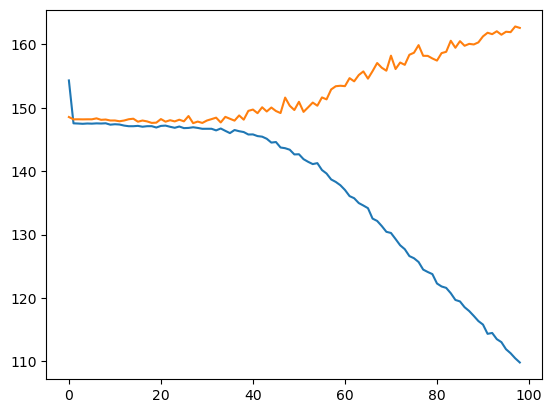

In [13]:
import keras
import tensorflow as tf

from keras import Sequential
from keras.layers import Dense

model=Sequential()
model.add(Dense(units=200, activation='tanh', input_shape=(49,)))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=200, activation='tanh'))
model.add(Dense(units=1))
model.summary()

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mean_squared_error'])

Hist=model.fit(X_train_CM_red, y_train_scaled, epochs=100, batch_size=64, validation_split=0.2)

plt.plot(Hist.history['loss'][1:])
plt.plot(Hist.history['val_loss'][1:])

model.predict(X_train_CM_red)

In [67]:
import numpy as np
import ase
from ase.calculators.lj import LennardJones
import matplotlib.pyplot as plt
from dscribe.descriptors import SOAP

# Setting up the SOAP descriptor
soap = SOAP(
    species=["O", "O", "H", "H", "H", "H", "H"],
    periodic=False,
    rcut=50,
    sigma=0.5,
    nmax=3,
    lmax=0,
)

# Generate dataset of Lennard-Jones energies and forces
traj = []
n_atoms = 7
#energies = np.zeros(n_samples)
#forces = np.zeros((n_samples, n_atoms, 3))
#r = np.linspace(2.5, 5.0, n_samples)
for i in range(X_train.shape[0]):
    a = Atoms("OOHHHHH", [(X_train[i][j][1], X_train[i][j][2], X_train[i][j][3]) for j in range(X_train.shape[1])])
#    a.set_calculator(LennardJones(epsilon=1.0 , sigma=2.9))
#    print(a)
    traj.append(a)
#    energies[i] = a.get_total_energy()
#    forces[i, :, :] = a.get_forces()

# Create the SOAP desciptors and their derivatives for all samples. One center
# is chosen to be directly between the atoms.
derivatives, descriptors = soap.derivatives(
    traj,
    positions=[[[0, 0, 0]]] *len(X_train),
    method="analytical"
)

# Save to disk for later training
np.save("E.npy", energies)
np.save("D.npy", descriptors)
np.save("dD_dr.npy", derivatives)

In [68]:
np.sum(descriptors==0)

0

In [75]:
derivatives

array([[[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -5.20659302e-06,  8.45856125e-06, -1.36480367e-05],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -7.29669840e-06,  1.18541184e-05, -1.91268277e-05],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -2.29498681e-05,  3.72840481e-05, -6.01584644e-05]],

         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -5.12198272e-06,  7.70416665e-06, -1.15871721e-05],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -8.86524892e-06,  1.33345540e-05, -2.00553517e-05],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           -1.85829203e-05,  2.79512686e-05, -4.20390907e-05]],

         [[-5.36144392e-09,  2.72548508e-07, -4.28239356e-07, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [-8.51035843e-09,  4.32623288e-07, -6.79755393e-07, ...,
            0.00000